In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
num_classes = 15 #yeh jitni class banegi utni kariyo
batch_size = 16
num_epochs = 15 #isko 25 kardiyo

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'split_data/train/',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        'split_data/val',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'split_data/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 5536 images belonging to 15 classes.
Found 686 images belonging to 15 classes.
Found 706 images belonging to 15 classes.


In [5]:
from tensorflow.keras import layers
# Define the input shape
input_shape = (224, 224, 3)

In [6]:
# Define the model architecture
model = Sequential()

# First convolutional block
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second convolutional block
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third convolutional block
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [7]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                        

In [8]:
# Define the number of steps per epoch
train_steps = train_generator.samples // batch_size
val_steps = validation_generator.samples // batch_size

In [33]:
# Train the model
history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=num_epochs,
        validation_data=validation_generator,
        validation_steps=val_steps)


Epoch 1/15
346/346 [==============================] - 978s 3s/step - loss: 0.2027 - accuracy: 0.3114 - val_loss: 0.1177 - val_accuracy: 0.6250
Epoch 2/15
346/346 [==============================] - 967s 3s/step - loss: 0.1126 - accuracy: 0.6635 - val_loss: 0.0974 - val_accuracy: 0.6964
Epoch 3/15
346/346 [==============================] - 1035s 3s/step - loss: 0.0914 - accuracy: 0.7402 - val_loss: 0.0912 - val_accuracy: 0.7202
Epoch 4/15
346/346 [==============================] - 1117s 3s/step - loss: 0.0750 - accuracy: 0.7910 - val_loss: 0.0823 - val_accuracy: 0.7679
Epoch 5/15
346/346 [==============================] - 1125s 3s/step - loss: 0.0608 - accuracy: 0.8351 - val_loss: 0.0899 - val_accuracy: 0.7649
Epoch 6/15
346/346 [==============================] - 1045s 3s/step - loss: 0.0478 - accuracy: 0.8759 - val_loss: 0.0845 - val_accuracy: 0.7574
Epoch 7/15
346/346 [==============================] - 1007s 3s/step - loss: 0.0389 - accuracy: 0.9113 - val_loss: 0.0876 - val_accuracy: 0

In [34]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('Test accuracy:', test_acc)

45/45 - 18s - loss: 0.1475 - accuracy: 0.7748 - 18s/epoch - 395ms/step
Test accuracy: 0.7747875452041626


In [35]:
import numpy as np
from sklearn.metrics import label_ranking_average_precision_score
from keras.utils import to_categorical

# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

# Get model predictions
y_pred = model.predict(test_generator)

# Calculate LWLRAP

y_true = to_categorical(test_generator.labels, num_classes=15)
lwlrAP = label_ranking_average_precision_score(y_true, y_pred)

# Calculate top-5 categorical accuracy
top_5_acc = 0
for i in range(len(test_generator)):
    batch = test_generator[i]
    x_batch, y_batch = batch[0], batch[1]
    y_pred_batch = model.predict(x_batch)
    top_5_acc += np.mean(np.any(np.argsort(y_pred_batch)[:,-5:] == np.argmax(y_batch, axis=1).reshape(-1,1), axis=1))
top_5_acc /= len(test_generator)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('LWLRAP:', lwlrAP)
print('Top-5 categorical accuracy:', top_5_acc)

1/1 [==============================] - 0s 92ms/step
Test loss: 0.14751356840133667
Test accuracy: 0.7747875452041626
LWLRAP: 0.8577460153947406
Top-5 categorical accuracy: 0.9638888888888889


In [36]:
from sklearn.metrics import classification_report
import numpy as np

# Get predicted labels
y_pred = model.predict(test_generator)

# Convert predicted probabilities to labels
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Calculate precision, recall, and F1 score
print(classification_report(y_true, y_pred, target_names=class_names))


45/45 [==============================] - 17s 369ms/step
                              precision    recall  f1-score   support

                    Apusapus       1.00      0.71      0.83         7
              Chlorischloris       0.76      0.69      0.73       113
Coccothraustescoccothraustes       0.95      0.90      0.93        21
             Columbapalumbus       0.84      0.81      0.83        53
            Corvusfrugilegus       0.80      0.80      0.80         5
             Delichonurbicum       0.00      0.00      0.00        11
            Dendrocoposmajor       0.00      0.00      0.00         6
               Motacillaalba       0.71      0.42      0.53        24
              Passermontanus       0.54      0.64      0.58        33
         Phoenicurusochruros       0.67      0.76      0.71        75
      Phoenicurusphoenicurus       0.71      0.91      0.80        90
       Phylloscopuscollybita       0.87      0.92      0.89       133
               Sittaeuropaea     

In [40]:
from sklearn.metrics import classification_report
import numpy as np

# Get predicted labels
y_pred = model.predict(test_generator)

# Convert predicted probabilities to labels
y_pred = np.argmax(y_pred, axis=1)

# Get the true positive, false positive, true negative, and false negative values
y_true = test_generator.labels

tp = np.sum((y_true == 1) & (y_pred == 1))
fp = np.sum((y_true == 0) & (y_pred == 1))
tn = np.sum((y_true == 0) & (y_pred == 0))
fn = np.sum((y_true == 1) & (y_pred == 0))

# Calculate precision, recall, and F1 score
precision = tp / (tp + fp + 1e-7)  # Add a small epsilon to avoid division by zero
recall = tp / (tp + fn + 1e-7)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)


45/45 [==============================] - 17s 364ms/step
Precision: 0.9999999987179488
Recall: 0.9999999987179488
F1 Score: 0.9999999487179513


In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score

# Load test data
test_generator = test_datagen.flow_from_directory(
    'split_data/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

# Load the saved model
# model = load_model('my_model.h5')

# Make predictions
y_pred = model.predict(test_generator)

# Convert labels to binary format
classes = np.unique(train_generator.classes)
y_true = label_binarize(test_generator.classes, classes=classes)

# Calculate average precision score for each class
map_score = average_precision_score(y_true, y_pred, average=None)

# Calculate mean average precision score
map_mean = map_score.mean()

print('Mean Average Precision (MAP): {:.4f}'.format(map_mean))


Found 706 images belonging to 15 classes.
45/45 [==============================] - 18s 391ms/step
Mean Average Precision (MAP): 0.0733


In [10]:
# Train the model
history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=num_epochs,
        validation_data=validation_generator,
        validation_steps=val_steps)


Epoch 1/10
346/346 [==============================] - 1169s 3s/step - loss: 0.1837 - accuracy: 0.3987 - val_loss: 0.1152 - val_accuracy: 0.6354
Epoch 2/10
346/346 [==============================] - 1095s 3s/step - loss: 0.1074 - accuracy: 0.6864 - val_loss: 0.1087 - val_accuracy: 0.6756
Epoch 3/10
346/346 [==============================] - 1076s 3s/step - loss: 0.0871 - accuracy: 0.7538 - val_loss: 0.0884 - val_accuracy: 0.7381
Epoch 4/10
346/346 [==============================] - 1043s 3s/step - loss: 0.0732 - accuracy: 0.7995 - val_loss: 0.0853 - val_accuracy: 0.7366
Epoch 5/10
346/346 [==============================] - 1135s 3s/step - loss: 0.0581 - accuracy: 0.8414 - val_loss: 0.0887 - val_accuracy: 0.7500
Epoch 6/10
346/346 [==============================] - 1098s 3s/step - loss: 0.0454 - accuracy: 0.8871 - val_loss: 0.0931 - val_accuracy: 0.7604
Epoch 7/10
346/346 [==============================] - 954s 3s/step - loss: 0.0355 - accuracy: 0.9193 - val_loss: 0.0912 - val_accuracy: 

In [12]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('Test accuracy:', test_acc)

45/45 - 17s - loss: 0.1055 - accuracy: 0.7507 - 17s/epoch - 380ms/step
Test accuracy: 0.7507082223892212


In [23]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('Test accuracy:', test_acc)

45/45 - 96s - loss: 0.1217 - accuracy: 0.7740 - 96s/epoch - 2s/step
Test accuracy: 0.7740113139152527


In [17]:
import numpy as np
from sklearn.metrics import label_ranking_average_precision_score
from keras.utils import to_categorical

# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

# Get model predictions
y_pred = model.predict(test_generator)

# Calculate LWLRAP

y_true = to_categorical(test_generator.labels, num_classes=15)
lwlrAP = label_ranking_average_precision_score(y_true, y_pred)

# Calculate top-5 categorical accuracy
top_5_acc = 0
for i in range(len(test_generator)):
    batch = test_generator[i]
    x_batch, y_batch = batch[0], batch[1]
    y_pred_batch = model.predict(x_batch)
    top_5_acc += np.mean(np.any(np.argsort(y_pred_batch)[:,-5:] == np.argmax(y_batch, axis=1).reshape(-1,1), axis=1))
top_5_acc /= len(test_generator)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('LWLRAP:', lwlrAP)
print('Top-5 categorical accuracy:', top_5_acc)

1/1 [==============================] - 0s 330ms/step
Test loss: 0.10553856194019318
Test accuracy: 0.7507082223892212
LWLRAP: 0.8447653896308286
Top-5 categorical accuracy: 0.9680555555555556


In [12]:
from sklearn.metrics import classification_report
import numpy as np

# Get predicted labels
y_pred = model.predict(test_generator)

# Convert predicted probabilities to labels
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Calculate precision, recall, and F1 score
print(classification_report(y_true, y_pred, target_names=class_names))


45/45 [==============================] - 30s 662ms/step
                              precision    recall  f1-score   support

                    Apusapus       1.00      0.43      0.60         7
              Chlorischloris       0.72      0.65      0.68       113
Coccothraustescoccothraustes       0.94      0.81      0.87        21
             Columbapalumbus       0.86      0.81      0.83        53
            Corvusfrugilegus       0.75      0.60      0.67         5
             Delichonurbicum       0.00      0.00      0.00        11
            Dendrocoposmajor       0.00      0.00      0.00         6
               Motacillaalba       0.57      0.33      0.42        24
              Passermontanus       0.43      0.27      0.33        33
         Phoenicurusochruros       0.53      0.75      0.62        75
      Phoenicurusphoenicurus       0.75      0.88      0.81        90
       Phylloscopuscollybita       0.80      0.89      0.84       133
               Sittaeuropaea     

C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


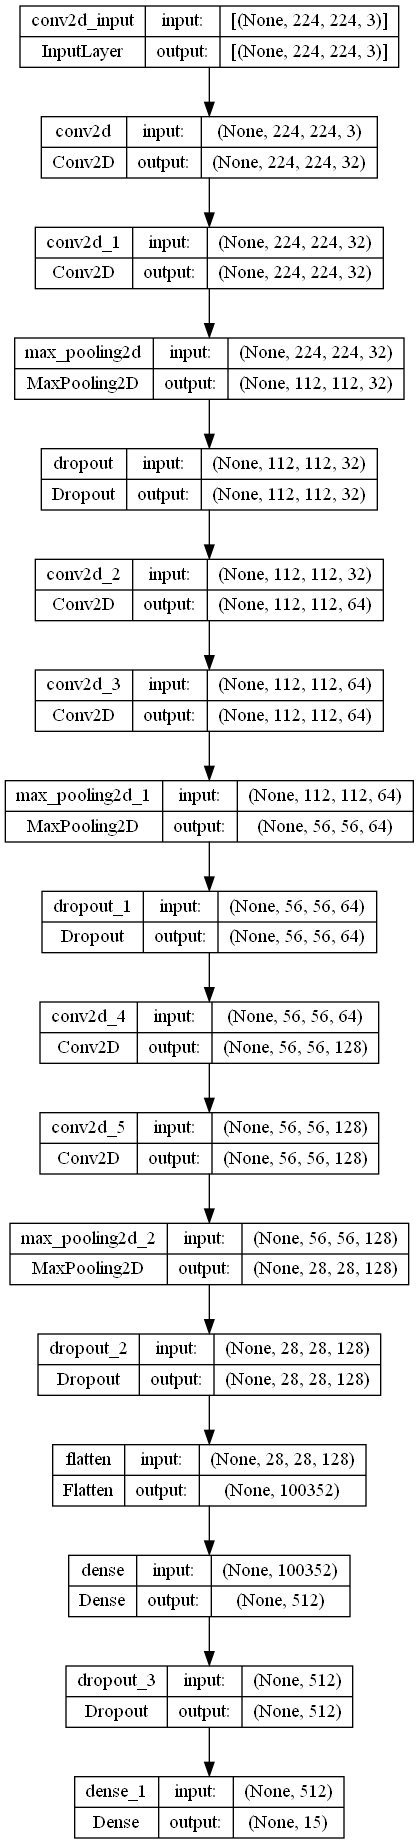

In [11]:
from tensorflow.keras.utils import plot_model

# Save a diagram of the model architecture to a file
plot_model(model, to_file='CNN.png', show_shapes=True, show_layer_names=True)


In [15]:
pip install visualkeras

     ---------------------------------------- 43.2/43.2 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


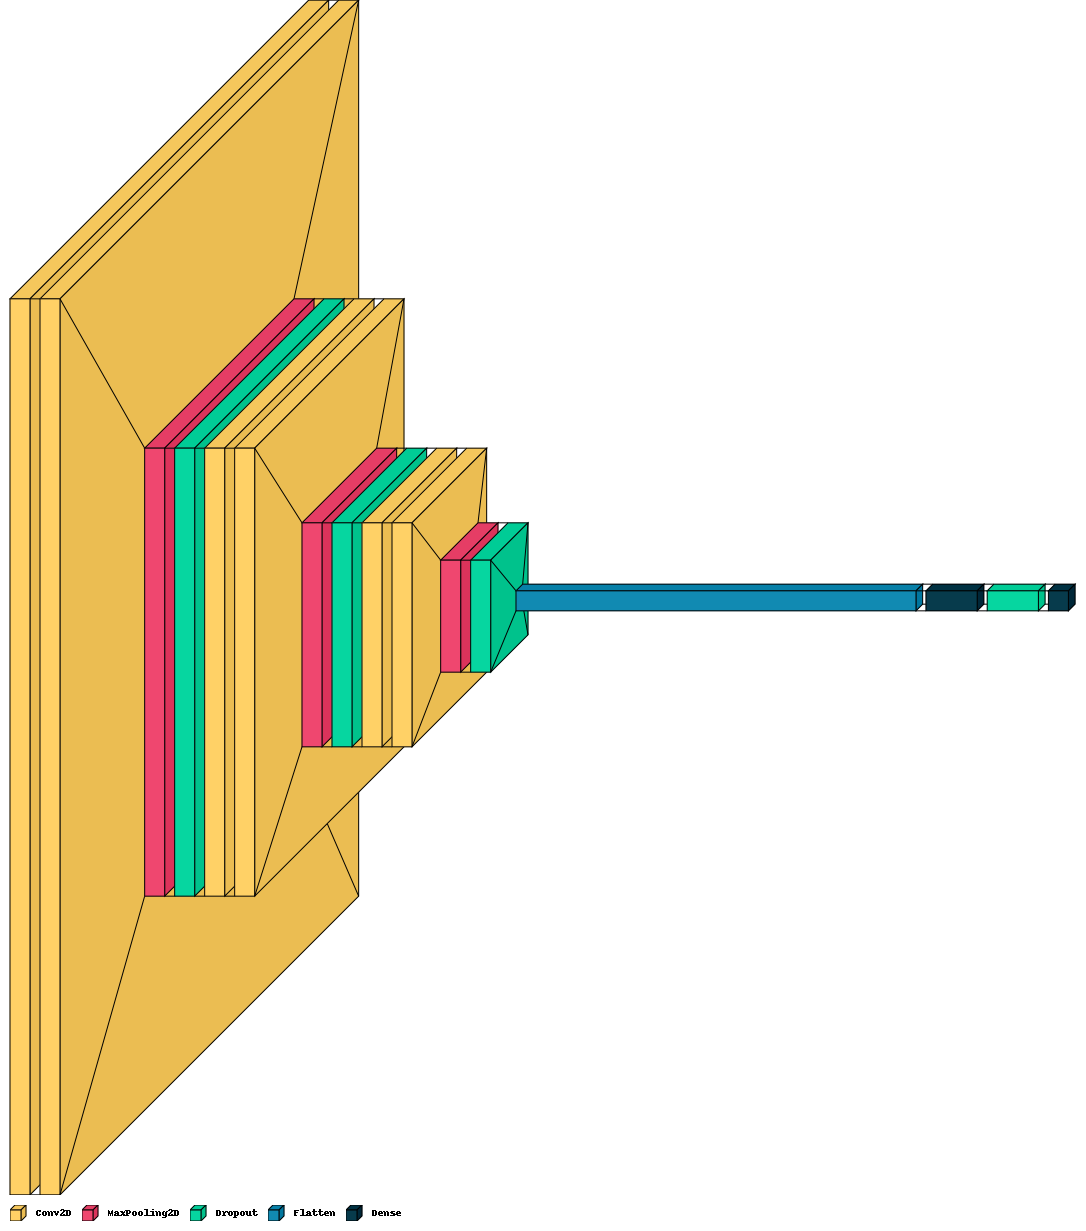

In [18]:
import visualkeras
from keras_visualizer import visualizer 

visualkeras.layered_view(model, legend=True) 